In [243]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import awkward as ak
from scipy.stats import chisquare
import scipy
from scipy.fft import fft, ifft
from scipy.signal import convolve as conv

In [244]:
channel = 6 #Canale di cui si effettua l'analisi

#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.25, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -50, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]
print(Vt, Q_max, Q_min)


-1.25 -50 -1000


In [245]:
PATH = '../ignore/Dati/Run_ch6_Cs_Measurements_Only_3_27_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../ignore/Dati/Run_ch6_X_Measurements_Only_3_26_2024.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

#Estrazione dati da file 

chargeCsT = np.array(RunCs['tree'].arrays()['charge'])
ampCsT = np.array(RunCs['tree'].arrays()['amp'])

chargeNT = np.array(RunNoise['tree'].arrays()['charge'])
ampNT= np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]

print("eventi segnale+rumore", evCsT)
print("eventi rumore", evNT)

eventi segnale+rumore 1000000
eventi rumore 300000


In [246]:
trueCs = ampCsT>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCsT[trueCs]
ampCs=ampCsT[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampNT>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeNT[trueX]
ampN=ampNT[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 6 = 847899
#Noise ripulita su ch 6 = 218713


In [247]:
#Funzioni utili
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

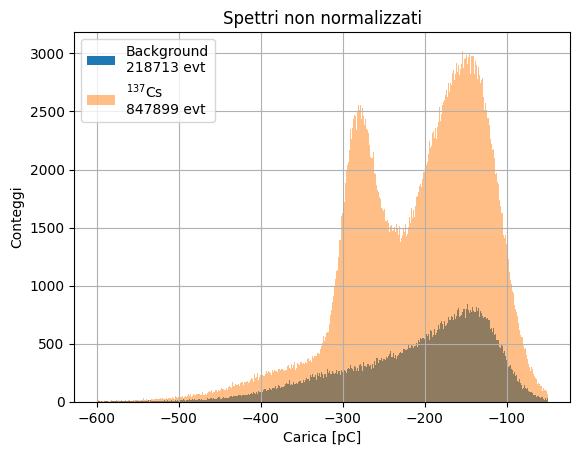

In [249]:
bin = 900 #Binnaggio scelto?

binN , edgeN , _= plt.hist(chargeN, bins=bin, range=(-600, Q_max), 
                           density = False, label = "Background\n" + str(len(chargeN)) + " evt")

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), 
                            density = False, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
#plt.ylim(0, 2000)
#plt.xlim(-800, -350)
plt.show()


Fit diretto sul picco (Esponenziale + gaussiana)

/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_42563/2554936685.py:2: RuntimeWarning: overflow encountered in exp
  return( alpha*np.exp(-(x-mu)**2/(2*sigma**2))+beta*np.exp(b*(x+a))+c)


params [ 8.18261869e+02  1.02196346e-02 -2.24255432e+02 -2.80529222e+02
  1.88351789e+01  1.76823171e+03  3.97723586e+00]
Power_divergenceResult(statistic=1.6135620915032667, pvalue=0.20399180383022358)
mu -280.52922161164497 sigma_fit 0.13754718349147368 sigma_mean 1.1462724866201577


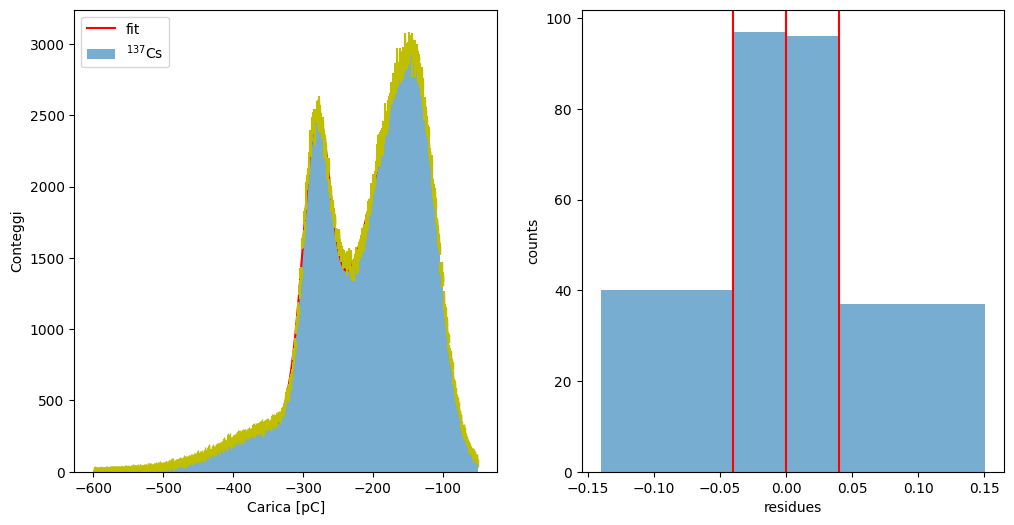

In [250]:
def fun(x, a, b, c, mu, sigma, alpha, beta):
    return( alpha*np.exp(-(x-mu)**2/(2*sigma**2))+beta*np.exp(b*(x+a))+c)

start=430
stop=700
x=np.linspace(edgeCs[start],edgeCs[stop], abs(start-stop))
y=binCs[start:stop]
p, covs=curve_fit(fun, x, y, p0=[600, 0.02, 0, -280, 20,400, 1], sigma=np.sqrt(y))
print("params", p)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x, fun(x, *p), color='r', label='fit')
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs', alpha=.6)
plt.legend()
trash = plt.errorbar(edgeCs[1:], binCs, np.sqrt(binCs), color='y', fmt='|')

plt.subplot(1,2,2)
x=(fun(x, *p)-binCs[start:stop])/binCs[start:stop]
mu=np.mean(x)
std=np.std(x, ddof=1)
a=plt.hist(x, bins=[min(x), mu-std, mu, mu+std, max(x)], rwidth=0.98, alpha=.6)
ek=[0.16*len(x),0.34*len(x),  0.34*len(x),0.16*len(x)]
print(chisquare(a[0], ek, ddof=2))
plt.axvline(x=mu+std, color='r')
plt.axvline(x=mu-std, color='r')
plt.axvline(x=mu, color='r')
plt.xlabel("residues")
plt.ylabel("counts")

print("mu",p[3], "sigma_fit", np.sqrt(covs[3][3]),"sigma_mean", p[4]/np.sqrt(abs(start-stop)))



Normalizzazione con rate e fit (gaussiana + Fermi Dirac)

In [190]:
durataX=1642 #s
durataCS=2964 #s


rateX=evNT/durataX
rateCs=evCsT/durataCS

print(durataCS/durataX)
Noise_to_add=int((durataCS-durataX)*rateX)
print("Elementi da aggiungere al rumore", Noise_to_add)
Noise_tot=evNT+Noise_to_add
print("Eventi di rumore rinormalizzati", Noise_tot)
chargeNT_ren=np.append(chargeNT, chargeNT[:int(Noise_to_add)])
ampNT_ren=np.append(ampNT, ampNT[:int(Noise_to_add)])

trueX = ampNT_ren>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN_ren = chargeNT_ren[trueX]
ampN_ren=ampNT_ren[trueX]

trueX = (chargeN_ren < Q_max) & (chargeN_ren > Q_min)
chargeN_ren = chargeN_ren[trueX]
ampN_ren=ampN_ren[trueX]
print("Eventi di rumore rinormalizzati e ripuliti", len(chargeN_ren))


1.805115712545676
Elementi da aggiungere al rumore 241534
Eventi di rumore rinormalizzati 541534
Eventi di rumore rinormalizzati e ripuliti 396413


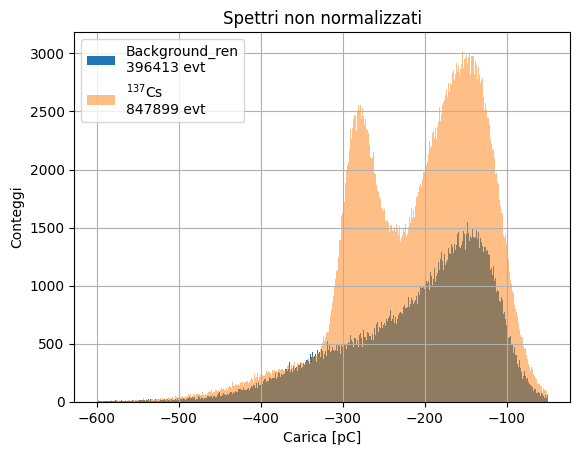

In [233]:
bin = 900 #Binnaggio scelto?

binN_ren, edgeN , _= plt.hist(chargeN_ren, bins=bin, range=(-600, Q_max), 
                           density = False, label = "Background_ren\n" + str(len(chargeN_ren)) + " evt")

binCs, edgeCs, _ = plt.hist(chargeCs, bins=bin, range=(-600, Q_max), 
                            density = False, label = r'$^{137}$Cs' + "\n" + str(len(chargeCs)) + " evt", alpha = 0.5)

plt.title("Spettri non normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
#plt.ylim(0, 2000)
#plt.xlim(-800, -350)
plt.show()

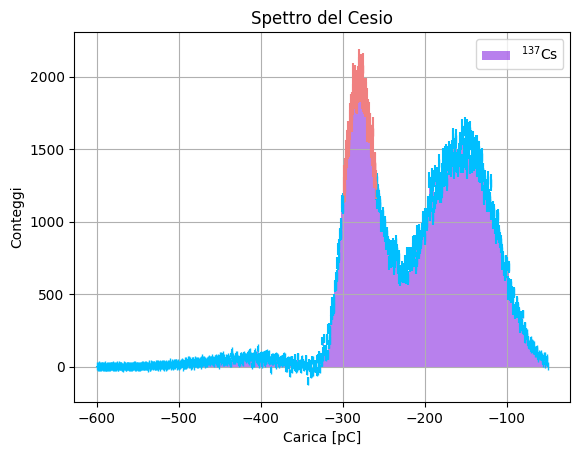

In [241]:
wdt = edgeN[1] - edgeN[0]
binSign = binCs - binN_ren

trash = plt.bar(edgeN[1:],binSign,width = wdt, label = r'$^{137}$Cs', color = "blueviolet", alpha=.6)

err = np.sqrt(binCs  + binN_ren )

#Determinazione del picco
peak_cntr = np.argmax(binSign)
peak_ledge = peak_cntr - 30
peak_redge = peak_cntr + 35


trash = plt.errorbar(edgeN[1:peak_ledge+1], binSign[:peak_ledge], err[:peak_ledge], color='deepskyblue', fmt='|')
trash = plt.errorbar(edgeN[peak_redge+1:], binSign[peak_redge:], err[peak_redge:], color='deepskyblue', fmt='|')

trash = plt.errorbar(edgeN[peak_ledge+1:peak_redge+1], 
                     binSign[peak_ledge:peak_redge], 
                     2*err[peak_ledge:peak_redge], 
                     color='lightcoral', fmt='|')



plt.title("Spettro del Cesio")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
#plt.savefig("../Fig/Spettro_Cs.png")
plt.show()


params [-279.5065292    20.91734481 1973.02299702]


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_42563/2607536779.py:23: RuntimeWarning: invalid value encountered in sqrt
  trash = plt.errorbar(edgeCs[1:], binSign, np.sqrt(binSign), color='y', fmt='|', alpha=0.5)


Power_divergenceResult(statistic=5.684389140271493, pvalue=0.017116497268369054)
mu 20.917344812887197 sigma_fit 0.34552514938654866 sigma_mean 2.59447731217742


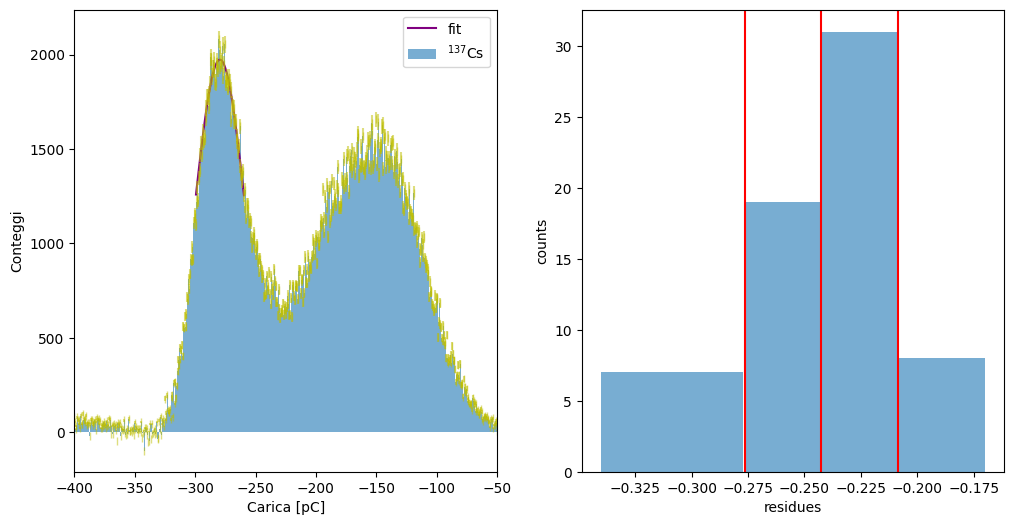

In [242]:
def fun(x, mu, sigma, alpha):
    #return( alpha*np.exp(-(x-mu)**2/(2*sigma**2))+beta*np.exp(b*(x+a))+c)
    #return( alpha*np.exp(-(x-mu)**2/(2*sigma**2))+beta*1/(np.exp(b*(x+a))+1)+c)
    return( alpha*np.exp(-(x-mu)**2/(2*sigma**2)))

start=peak_ledge
stop=peak_redge
x=np.linspace(edgeCs[start],edgeCs[stop], abs(start-stop))
y=binSign[start: stop]
p0=[ -280, 20,2000]
p, covs=curve_fit(fun, x, y, p0=p0, sigma=np.sqrt(y))
print("params", p)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(x, fun(x, *p), color='purple', label='fit')
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binSign, width=wdt, label = r'$^{137}$Cs', alpha=.6)
plt.legend()
plt.xlim(-400, Q_max)
trash = plt.errorbar(edgeCs[1:], binSign, np.sqrt(binSign), color='y', fmt='|', alpha=0.5)

plt.subplot(1,2,2)
x=(fun(x, *p)-binCs[start:stop])/binCs[start:stop]
mu=np.mean(x)
std=np.std(x, ddof=1)
a=plt.hist(x, bins=[min(x), mu-std, mu, mu+std, max(x)], rwidth=0.98, alpha=.6)
ek=[0.16*len(x),0.34*len(x),  0.34*len(x),0.16*len(x)]
print(chisquare(a[0], ek, ddof=2))
plt.axvline(x=mu+std, color='r')
plt.axvline(x=mu-std, color='r')
plt.axvline(x=mu, color='r')
plt.xlabel("residues")
plt.ylabel("counts")

print("mu",p[1], "sigma_fit", np.sqrt(covs[1][1]),"sigma_mean", p[1]/np.sqrt(abs(start-stop)))

Prove con convoluzioni

-324.6941045606229
(875,)
[ 1.-0.00000000e+00j -1.-1.73472348e-17j  1.-9.71445147e-17j
 -1.-1.24900090e-16j  1.+3.46944695e-17j -1.-1.38777878e-17j
  1.+1.24900090e-16j -1.+9.71445147e-17j  1.-4.16333634e-17j
 -1.+9.71445147e-17j  1.-2.22044605e-16j -1.+0.00000000e+00j
  1.-1.11022302e-16j -1.-1.66533454e-16j  1.-5.55111512e-17j
 -1.-1.94289029e-16j  1.+1.38777878e-16j -1.-5.55111512e-17j
  1.+8.32667268e-17j -1.+1.11022302e-16j  1.-1.11022302e-16j
 -1.+0.00000000e+00j  1.-5.55111512e-17j -1.-1.66533454e-16j
  1.-5.55111512e-17j -1.+1.11022302e-16j  1.+0.00000000e+00j
 -1.+1.11022302e-16j  1.+0.00000000e+00j -1.+0.00000000e+00j
  1.-1.66533454e-16j -1.+5.55111512e-17j  1.-1.11022302e-16j
 -1.+1.11022302e-16j  1.-5.55111512e-17j -1.+4.44089210e-16j
  1.-1.11022302e-16j -1.+1.11022302e-16j  1.+5.55111512e-17j
 -1.-5.55111512e-17j  1.+3.88578059e-16j -1.+0.00000000e+00j
  1.+1.11022302e-16j -1.-5.55111512e-17j  1.+0.00000000e+00j
 -1.-5.55111512e-17j  1.+0.00000000e+00j -1.-5.55111512e-17

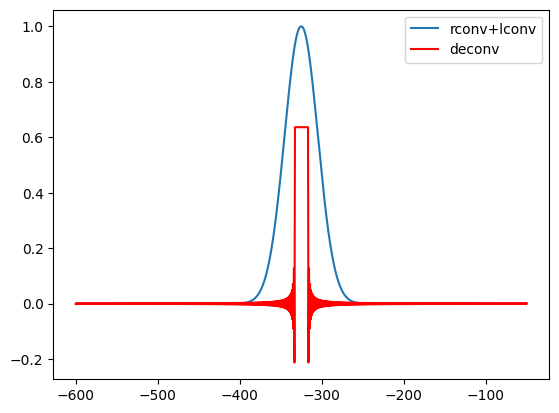

In [177]:
x=np.linspace(-600, Q_max, 900)
r=gaussian(x, 1, -600, 20)
R=fft(r)
l=gaussian(x, 1, -50, 20)
L=fft(l)
d=0*x
d[450:451]=1
D=fft(d)
rconv=ifft(D*R)
lconv=ifft(D*L)
plt.plot(x, lconv+rconv, label='rconv+lconv')
CONV=fft(lconv+rconv)
print(x[np.argmax(lconv+rconv)])
#plt.plot(x, CONV)
true=abs(R+L)>1e-5
deconv=ifft(CONV[true]/(R+L)[true])
print(deconv.shape)
plt.plot(x[true], np.real(deconv), 'r', label='deconv')
print(D)
plt.legend()
#plt.xlim(-340, -300)




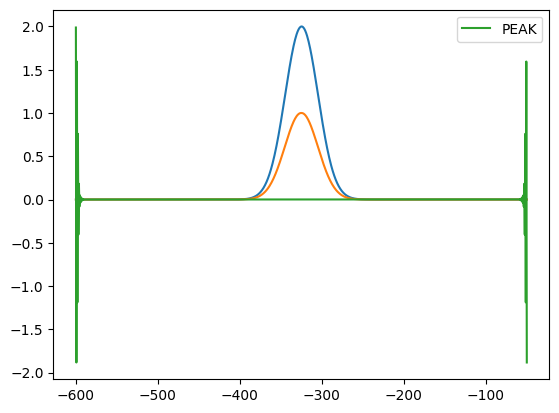

In [174]:
x=np.linspace(-600, Q_max, 900)
peak=gaussian(x, 2, -324.6941045606229, 20)
plt.plot(x, peak)
plt.plot(x, (lconv+rconv))
PEAK=fft(peak)
r=gaussian(x, 1, -600, 40)
R=fft(r)
l=gaussian(x, 1, -50, 40)
L=fft(l)
d=0*x
d[450:451]=1
D=fft(d)
deconv=ifft(PEAK[true]/(R+L)[true])
#plt.plot(x[true], CONV[true]/(R+L)[true], label='CONV')
plt.plot(x[true], PEAK[true]/(R[true]), label='PEAK')
#plt.plot(x[true], np.real(deconv), 'b', label='deconv')
#plt.xlim(-340, -300)
#plt.plot(x[true], np.real((CONV-PEAK)[true]), label='diff')
plt.legend()

[26859.24838848+0.j 25496.04351401+0.j 21807.68674913+0.j
 16807.54493986+0.j 11672.31056815+0.j  7304.10924344+0.j
  4118.46669294+0.j  2092.48198885+0.j   957.9564617 +0.j
   395.17338431+0.j]


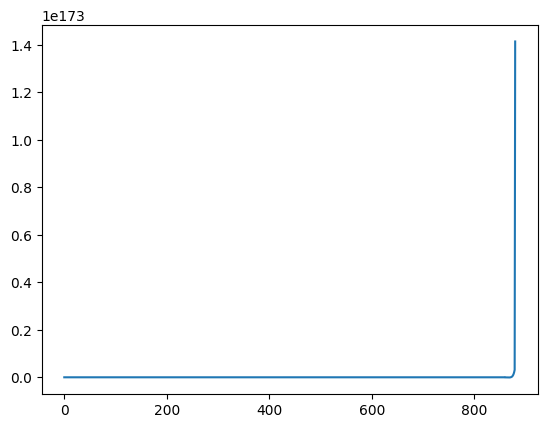

In [172]:
x=np.linspace(-600, Q_max, 900)
peak=gaussian(x, 2, -324.6941045606229, 20)
PEAK=fft(peak)*np.conjugate(fft(peak)) 
print(PEAK[:10])  
r=gaussian(x, 1, -600, 40)
R=fft(r) 
G=  
out=scipy.signal.deconvolve(peak,gaussian(x[:20], 2, -50, 30))
plt.plot(out[0])

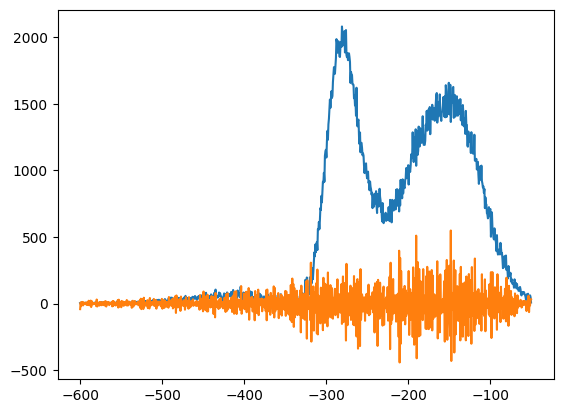

In [132]:
plt.plot(x, binSign)
SIGN=fft(binSign)
dec=ifft(SIGN[true]/(R*L)[true])
plt.plot(x[true], dec)

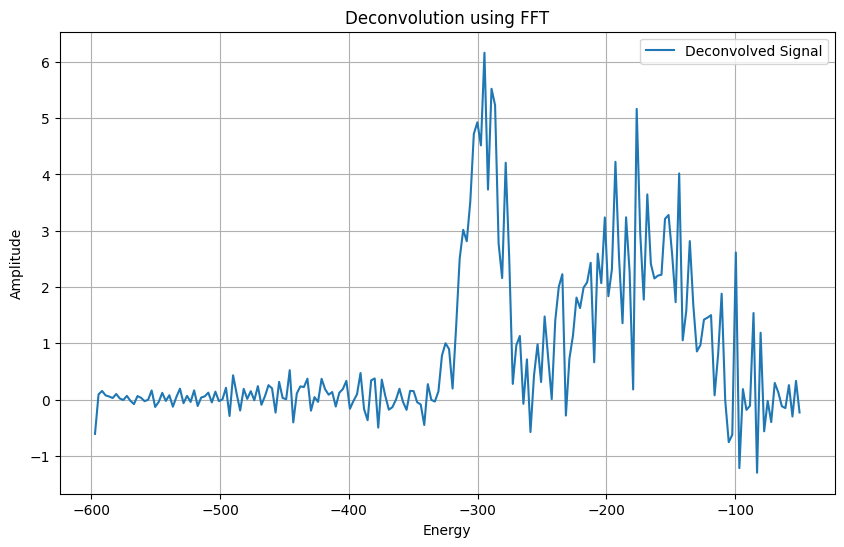

In [402]:
import numpy as np
import matplotlib.pyplot as plt

def gauss(E, mu, sigma, amp):
    return amp * np.exp(-np.power((E - mu) / sigma, 2.0) / 2)

def resolution(E, sigma, amp):
    gauss_vals = gauss(E, -600, sigma, amp)
    return gauss_vals / np.max(gauss_vals)

# Assuming binSign and edgeN are defined somewhere in your code
# Ensure they are properly defined before using them in the following code

# Perform deconvolution
res = resolution(edgeN[1:], 30, 1 / np.sqrt(2 * np.pi * 30))
sig = np.fft.fft(binSign)
res_fft = np.fft.fft(res)

# Avoid division by zero and normalize res_fft
res_fft_normalized = np.where(np.abs(res_fft) > 1e-6, res_fft, 1e-6)
deconv = np.fft.ifft(sig / res_fft_normalized)  # Perform deconvolution

# Normalize the result
deconv /= len(deconv)


# Plot results
plt.figure(figsize=(10, 6))
#plt.plot(edgeN[1:], binSign, label='Original Signal')
plt.plot(edgeN[1:], np.real(deconv), label='Deconvolved Signal')
plt.xlabel('Energy')
plt.ylabel('Amplitude')
plt.title('Deconvolution using FFT')
plt.legend()
plt.grid(True)
plt.show()


200


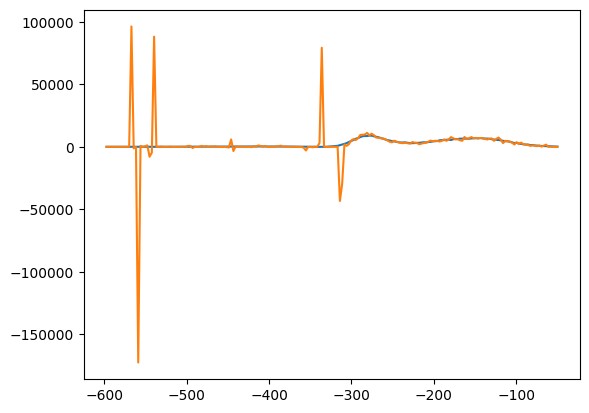

In [379]:
def richardson_lucy_deconvolution(convolved, kernel, iterations=100):
    def rl_objective(signal_estimate):
        return np.sum((scipy.signal.convolve(signal_estimate, kernel, mode='same') - convolved) ** 2)

    signal_estimate = np.ones_like(convolved)

    for _ in range(iterations):
        error = convolved / (scipy.signal.convolve(signal_estimate, kernel, mode='same') + 1e-9)
        signal_estimate *= scipy.signal.convolve(error, np.flip(kernel), mode='same')

    return signal_estimate

gaussian_kernel=scipy.signal.gaussian(11, std=20)
reconstructed_signal = richardson_lucy_deconvolution(binSign, gaussian_kernel)
print(len(reconstructed_signal))

plt.plot(edgeN[1:], binSign)
plt.plot(edgeN[1:], reconstructed_signal, label='deconv')


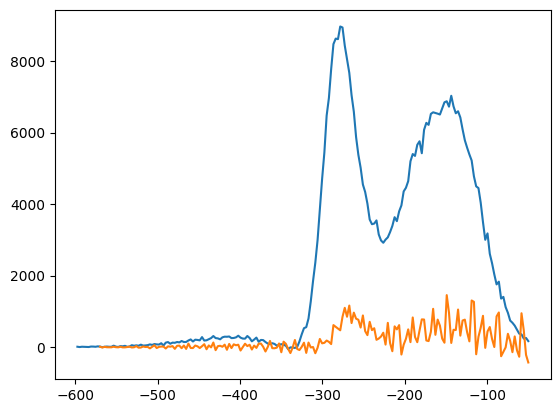

In [387]:
from scipy import signal
recovered, remainder = signal.deconvolve(binSign, gaussian_kernel)
plt.plot(edgeN[1:], binSign)
plt.plot(edgeN[11:], recovered, label='deconv')


Convoluzione con gaussiana

/Users/martinachirico/miniconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


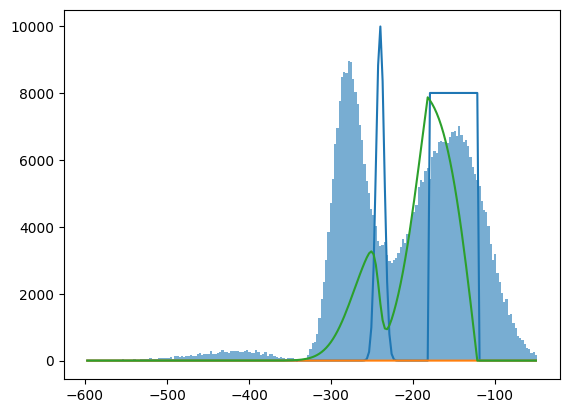

In [307]:
def gauss(E, mu, sigma, amp):
    return amp* np.exp(-np.power((E - mu) / sigma, 2.0) / 2)

def spectrum (E):
    f1=np.zeros_like(E)
    
    #mask = (0.1 < E) & (E < 0.95)  # Create a mask for E values in range (0.1, 0.95)
   
    f1=8000*(np.heaviside((E+180), 1)*np.heaviside((-E-120), 1))
    return f1 + gauss(E, -240, 5, 10000) 



plt.plot(edgeN[1:], spectrum(edgeN[1:]))
trash = plt.bar(edgeN[1:], binSign, width=wdt, label = r'$^{137}$Cs', alpha=.6)

def resolution (E, sigma, amp):
    return gauss(E, -50, sigma, amp)

std=30
res=fft(resolution(edgeN[1:], std, 1/np.sqrt(2*np.pi*std)))
signal=fft(spectrum(edgeN[1:]))
conv=ifft(signal*res)
plt.plot(edgeN[1:], resolution(edgeN[1:], std, 1/np.sqrt(2*np.pi*std)))
plt.plot(edgeN[1:], conv)


params [ -260. 30000.  -100.  -600.  8000.]


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_38726/1086380494.py:19: RuntimeWarning: invalid value encountered in sqrt
  p, covs=curve_fit(convolution, x, y, p0=p0, sigma=np.sqrt(y))


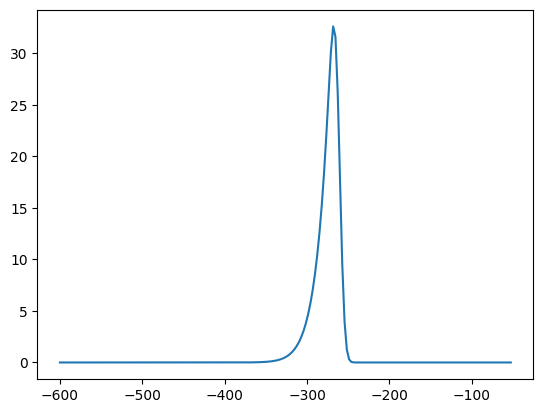

In [330]:
def convolution(x, mu_peak, amp_peak, compton_start, compton_stop, compton_amp ):
    compton=compton_amp*(np.heaviside((x-compton_start), 1)*np.heaviside((-x+compton_stop), 1))
    signal=amp_peak* np.exp(-np.power((x - mu_peak) / 5, 2.0) / 2)+compton
    resolution=1/np.sqrt(2*np.pi*100)*np.exp(-np.power((x - 100) / 50, 2.0) / 2)
    res=fft(resolution)
    sig=fft(signal)
    conv=ifft(sig*res)
    return(np.real(conv))



start=0
stop=199
x=np.linspace(edgeCs[start],edgeCs[stop], abs(start-stop))
y=binSign[start: stop]
p0=[-260, 30000,  -100, -600,8000]
#print(convolution(x,*p0))
plt.plot(x, convolution(x,*p0))
p, covs=curve_fit(convolution, x, y, p0=p0, sigma=np.sqrt(y))
print("params", p) 

In [214]:
print(np.heaviside(-150,-200))

0.0


Normalizzazione con media

/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_42563/726636926.py:2: RuntimeWarning: divide by zero encountered in divide
  avg_coda = ( binCs / binN)[:int(bin * 30 / 100)].mean()
/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_42563/726636926.py:4: RuntimeWarning: invalid value encountered in multiply
  binN_Ren = binN* avg_coda #Moltiplicando per 1.5 viene molto meglio... mhhh


avg_coda inf


/Users/martinachirico/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3648: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err
/Users/martinachirico/miniconda3/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


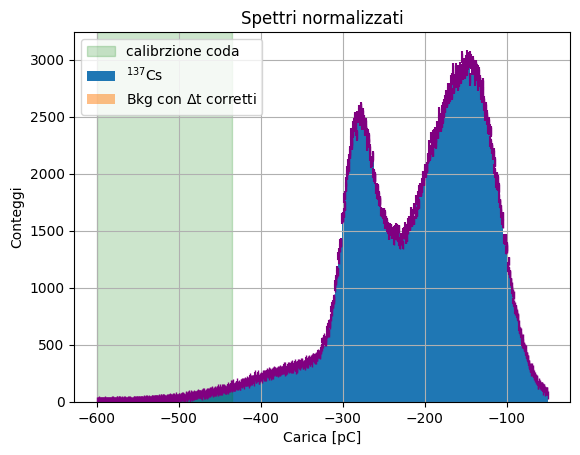

In [204]:
#Rinormalizzazione con media
avg_coda = ( binCs / binN)[:int(bin * 30 / 100)].mean()
print("avg_coda", avg_coda)
binN_Ren = binN* avg_coda #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[0], edgeN[int(bin * 30 / 100)], color='green', alpha=0.2, label = "calibrzione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()



Normalizzazione con integrale

3.0719327731092436


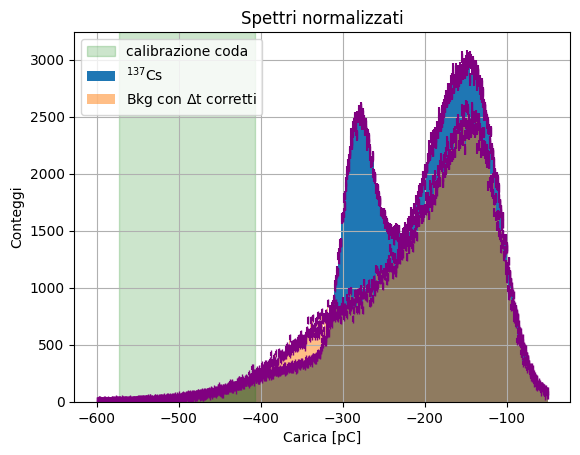

In [207]:
#Rinormalizzazione con integrale
rin_lim = [int(bin * 5 / 100), int(bin * 35 / 100)]
rin_f =  binCs[rin_lim[0]:rin_lim[1]].sum() / binN[rin_lim[0]:rin_lim[1]].sum()
print(rin_f)
binN_Ren = binN * rin_f #Moltiplicando per 1.5 viene molto meglio... mhhh

wdt = edgeN[1] - edgeN[0]
trash = plt.bar(edgeN[1:], binCs, width=wdt, label = r'$^{137}$Cs')
trash = plt.bar(edgeN[1:], binN_Ren, width=wdt, label = r'Bkg con $\Delta$t corretti', alpha = 0.5)

errCs = np.sqrt(binCs)
errN  = np.sqrt(binN_Ren)

trash = plt.errorbar(edgeN[1:], binN_Ren, errN, color='purple', fmt='|')
trash = plt.errorbar(edgeCs[1:], binCs, errCs, color='purple', fmt='|')

plt.axvspan(edgeN[rin_lim[0]], edgeN[rin_lim[1]], color='green', alpha=0.2, label = "calibrazione coda")


plt.title("Spettri normalizzati")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettri_Normalizzati_.png")
plt.show()



[ 9.52862185e+02  9.08583054e-03 -2.51106714e+02 -3.54922832e+02
  3.66156447e+01  3.89823896e+02  6.72541518e+00]
[[ 1.69009482e+15 -1.68401900e+02 -2.07262314e+07  1.40586771e+07
   1.61712301e+06 -4.70386907e+07 -1.03231363e+14]
 [-1.68401900e+02  3.94473587e-08  4.30504296e-03  1.71957079e-04
   4.76616892e-04  4.13439594e-03  1.02858261e+01]
 [-2.07262314e+07  4.30504296e-03  5.94495000e+02  2.26808106e+01
   4.26706950e+01  3.87622303e+02  1.26594087e+06]
 [ 1.40586771e+07  1.71957079e-04  2.26808106e+01  5.73366966e+00
   2.21256746e+00  1.71108357e+01 -8.58707984e+05]
 [ 1.61712301e+06  4.76616892e-04  4.26706950e+01  2.21256746e+00
   1.17092347e+01  3.31135856e+01 -9.87766402e+04]
 [-4.70386907e+07  4.13439594e-03  3.87622303e+02  1.71108357e+01
   3.31135856e+01  8.58418087e+02  2.87311276e+06]
 [-1.03231363e+14  1.02858261e+01  1.26594087e+06 -8.58707984e+05
  -9.87766402e+04  2.87311276e+06  6.30539439e+12]]


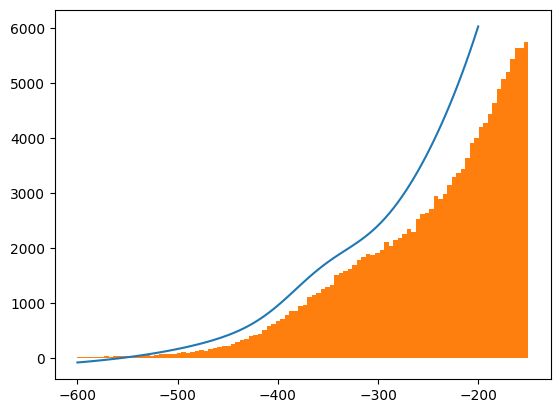

In [186]:
def fun(x, a, b, c, mu, sigma, alpha, beta):
    return( alpha*np.exp(-(x-mu)**2/(2*sigma**2))+beta*np.exp(b*(x+a))+c)

x=np.linspace(-600, -200, 100)
y=binN
p, covs=scipy.optimize.curve_fit(fun, x, y, p0=[600, 0.02, 0, -300, 200,0, 1])
print(p)
print(covs)

#plt.plot(x, fun(x, +600, 0.021, 0, -320, 20, 500 ))
plt.plot(x, fun(x, p[0], p[1], p[2], p[3], p[4], p[5], p[6]))
a=plt.hist(chargeN, bins=100, range=(-600, Q_max))

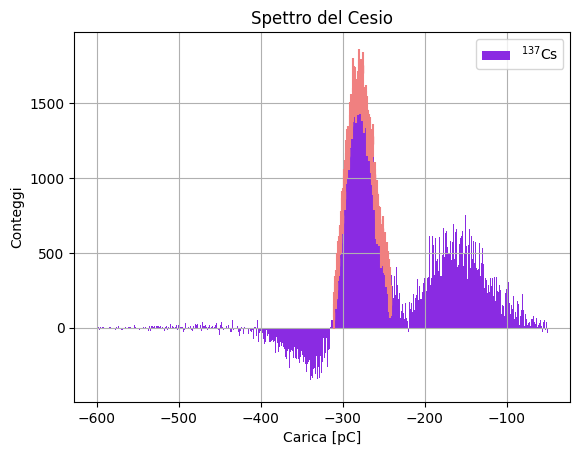

In [208]:
wdt = edgeN[1] - edgeN[0]
binSign = binCs - binN_Ren

trash = plt.bar(edgeN[1:],binSign,width = wdt, label = r'$^{137}$Cs', color = "blueviolet")

err = np.sqrt(binCs  + binN_Ren )

#Determinazione del picco
peak_cntr = np.argmax(binSign)
peak_ledge = peak_cntr - 50
peak_redge = peak_cntr + 65


#trash = plt.errorbar(edgeN[1:peak_ledge+1], binSign[:peak_ledge], err[:peak_ledge], color='deepskyblue', fmt='|')
#trash = plt.errorbar(edgeN[peak_redge+1:], binSign[peak_redge:], err[peak_redge:], color='deepskyblue', fmt='|')

trash = plt.errorbar(edgeN[peak_ledge+1:peak_redge+1], 
                     binSign[peak_ledge:peak_redge], 
                     2*err[peak_ledge:peak_redge], 
                     color='lightcoral', fmt='|')



plt.title("Spettro del Cesio")
plt.ylabel("Conteggi")
plt.xlabel("Carica [pC]")
plt.grid()
plt.legend()
plt.savefig("../Fig/Spettro_Cs.png")
plt.show()


Valor medio = -278.2pC
Dev std = 15.5pC


/var/folders/f5/v4f5q2zj2c19xqbmyrk3xnq40000gn/T/ipykernel_42563/2691465978.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")


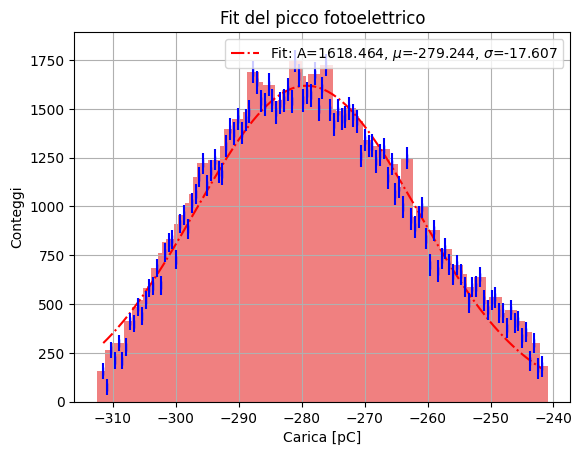

Chi-quadro: 384.60628643900503
dof: 115


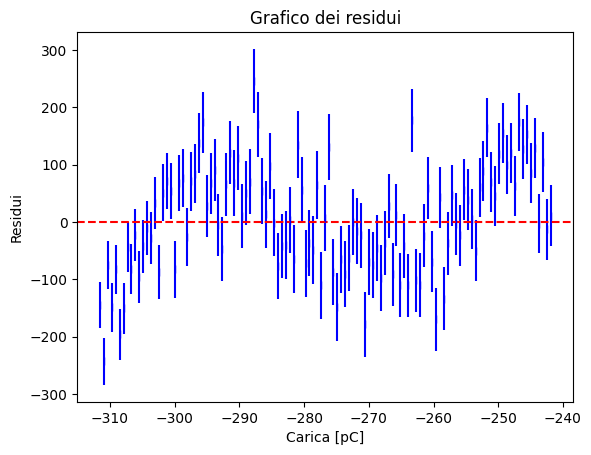

In [209]:
from scipy.optimize import curve_fit
#Isolo la parte di spettro legata al fotoelettrico
edge_photo=edgeN[peak_ledge:peak_redge]
counts_photo=binSign[peak_ledge:peak_redge]
err_photo=err[peak_ledge:peak_redge]

#bin_centers = (edge_photo[:-1] + edge_photo[1:]) / 2
bin_centers=edge_photo
# Calcoliamo il valore rappresentativo pesato dai conteggi di ciascun bin
weighted_values = bin_centers * counts_photo

# Calcoliamo la media pesata
weighted_mean = np.sum(weighted_values) / np.sum(counts_photo)

# Calcoliamo la deviazione standard pesata
weighted_std = np.sqrt(np.sum(counts_photo * (bin_centers - weighted_mean)**2) / np.sum(counts_photo))

print("Valor medio = " + str(round(weighted_mean, 1)) + "pC")
print("Dev std = " + str(round(weighted_std, 1)) + "pC")



# Facciamo il fit della gaussiana ai dati
popt, pcov = curve_fit(gaussian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo,
                        maxfev = 5000)

# Plot dell'istogramma e della curva di fit
plt.bar(edge_photo,counts_photo,width=2, color = "lightcoral")
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, gaussian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt), ls = "-.")
plt.errorbar(edge_photo, counts_photo, err_photo, color='blue', fmt='|')
plt.legend()
plt.xlabel('Carica [pC]')
plt.ylabel('Conteggi')
plt.title("Fit del picco fotoelettrico")
plt.grid()
plt.savefig("../Fig/Picco_Cs.png")
plt.show()


#fare chi quadro e residui
valori_previsti = gaussian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Carica [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

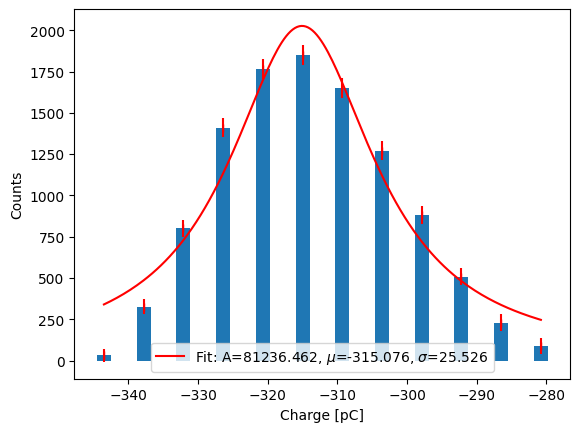

In [319]:
def lorentzian(x, A, x0, L):
    return A / (2 * np.pi) * L / ((x - x0)**2 + (0.5 * L)**2)


popt, pcov = curve_fit(lorentzian, bin_centers, counts_photo, p0=[1, weighted_mean, weighted_std], sigma=err_photo)

# Plot dell'istogramma e della curva di fit
#plt.hist(dati, bins=30, density=True, alpha=0.5, color='b', label='Istogramma dei dati')
plt.bar(edge_photo,counts_photo,width=2)
x_values=np.linspace(np.min(edge_photo), np.max(edge_photo), 200)
plt.plot(x_values, lorentzian(x_values, *popt), 'r-', label='Fit: A=%5.3f, $\mu$=%5.3f, $\sigma$=%5.3f' % tuple(popt))
plt.errorbar(edge_photo, counts_photo, err_photo, color='red', fmt='|')
plt.legend()
plt.xlabel('Charge [pC]')
plt.ylabel('Counts')
plt.show()

Chi-quadro: 138.1997963392976
dof: 12


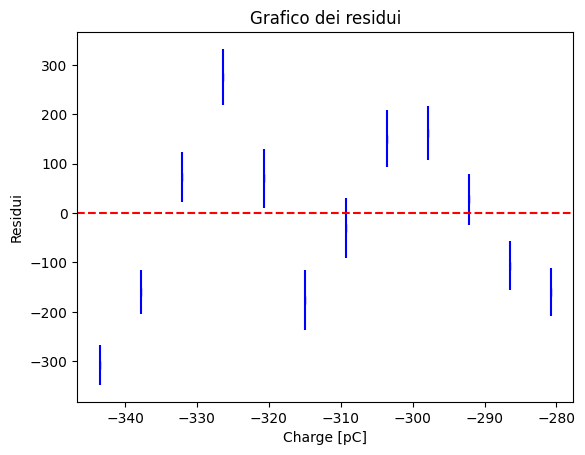

In [320]:
#fare chi quadro e residui
valori_previsti = lorentzian(edge_photo, *popt)

# 2. Calcola il chi-quadro
chi_quadro = np.sum(((counts_photo - valori_previsti) / err_photo)**2)

print("Chi-quadro:", chi_quadro)
print("dof:", np.size(counts_photo))

# 3. Calcola i residui
residui = counts_photo - valori_previsti

# 4. Traccia il grafico dei residui
plt.errorbar(edge_photo, residui, err_photo,color='blue', fmt='|')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Charge [pC]')
plt.ylabel('Residui')
plt.title('Grafico dei residui')
plt.show()

Prove fallimentari 

In [ ]:
import pybaselines
import scipy
from pybaselines.polynomial import poly
print(binN.shape)
x=np.arange(100)
baseline=scipy.signal.savgol_filter( binN, 90,  polyorder=7 )
coeffs=scipy.signal.savgol_coeffs( binN,  polyorder=7)
print(coeffs)
plt.plot(x,binN)
#print(baseline)
plt.plot(x, baseline, '.')


a=np.polyfit(x, binN, deg=5)
print(a)
def fun(x, a):
    return(a[0]*pow(x, 6)+a[1]*pow(x, 5)+a[2]*pow(x, 4)+a[3]*pow(x, 3)+ a[4]*x**2+a[5]*x+a[6])

plt.plot(x, binN)
plt.plot(x, fun(x, a))

plt.plot(x, binCs)

mean=np.mean()

plt.plot(x, 2*fun(x, a))

1.0


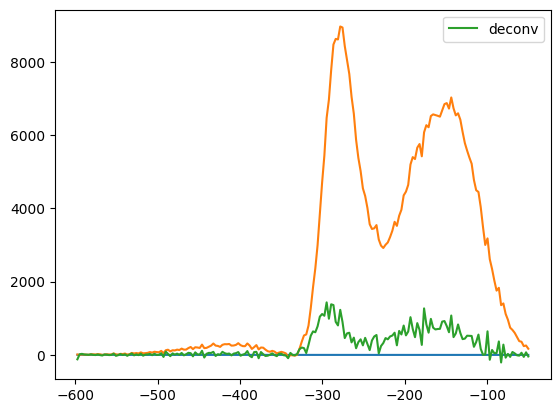

In [393]:
def gauss(E, mu, sigma, amp):
    return amp* np.exp(-np.power((E - mu) / sigma, 2.0) / 2)

def resolution (E, sigma, amp):
    return gauss(E, -600, sigma, amp)/np.max(gauss(E, -600, sigma, amp))

print(np.max(resolution(edgeN[1:], 20, 1/np.sqrt(2*np.pi*20))))
plt.plot(edgeN[1:], resolution(edgeN[1:], 20, 1/np.sqrt(2*np.pi*20)))

res=fft(resolution(edgeN[1:], 20, 1/np.sqrt(2*np.pi*20)))
sig=fft(binSign)
deconv=ifft(sig/res)
plt.plot(edgeN[1:], binSign)
plt.plot(edgeN[1:], deconv, label='deconv')
plt.legend()